In [1]:
import onnxmltools
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model
import onnx


In [2]:
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для проверки
val_dir = 'val'
# Каталог с данными для тестирования
test_dir = 'test'
# Размеры изображения
img_width, img_height = 128, 128
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3) 
# Количеств эпох
epochs = 15
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 500
# Количество изображений для проверки
nb_validation_samples = 100
# Количество изображенй для тестирования
nb_test_samples = 100

**Model Layers**

In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [4]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [5]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [6]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 3010 images belonging to 2 classes.


In [7]:
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 644 images belonging to 2 classes.


In [8]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 646 images belonging to 2 classes.


In [9]:
hist=model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/15
31/31 [==============================] - 9s 244ms/step - loss: 0.5808 - accuracy: 0.6855 - val_loss: 0.1949 - val_accuracy: 0.9896
Epoch 2/15
31/31 [==============================] - 7s 236ms/step - loss: 0.2285 - accuracy: 0.9066 - val_loss: 0.1104 - val_accuracy: 1.0000
Epoch 3/15
31/31 [==============================] - 8s 239ms/step - loss: 0.0937 - accuracy: 0.9637 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 4/15
31/31 [==============================] - 8s 243ms/step - loss: 0.0529 - accuracy: 0.9839 - val_loss: 0.0394 - val_accuracy: 0.9896
Epoch 5/15
31/31 [==============================] - 8s 242ms/step - loss: 0.0453 - accuracy: 0.9819 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 6/15
31/31 [==============================] - 7s 240ms/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 7/15
31/31 [==============================] - 8s 245ms/step - loss: 0.0198 - accuracy: 0.9940 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 

In [10]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)

print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))


C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_6120/980662612.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)


Точность на тестовых данных: 98.96%


**To ONNX and From ONNX**

In [11]:
from keras.models import Model, model_from_json

model_json = model.to_json()
json_file = open('model.json', 'w')
json_file.write(model_json)
json_file.close()

onnx_model = onnxmltools.convert_keras(model)
onnxmltools.utils.save_model(onnx_model, 'model.onnx')

model.save_weights('model_cnn.h5')






json_file = open("model.json", "r")
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model_cnn.h5")


loaded_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


**Test on 3 new IMAGES**

In [12]:
test_generator2 = datagen.flow_from_directory(
    'test-2',
    target_size=(img_width, img_height),
    batch_size=3,
    class_mode='binary')

scores2 = loaded_model.evaluate_generator(test_generator2, 3 // 3)

print("Точность на тестовых данных: %.2f%%" % (scores2[1]*100))


Found 3 images belonging to 1 classes.


C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_6120/1102719947.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores2 = loaded_model.evaluate_generator(test_generator2, 3 // 3)


Точность на тестовых данных: 100.00%


**PLOT**

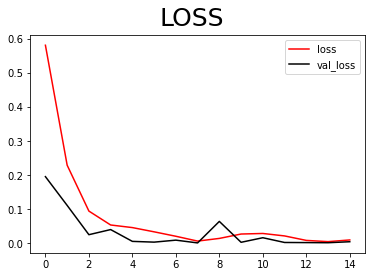

In [13]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='black', label='val_loss')
fig.suptitle('LOSS', fontsize=25)
plt.legend(loc="upper right")
plt.show()